# Flight efficiency map

Load packages, load data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from cmcrameri import cm as scm
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [4]:
flights = pd.read_csv("../data/by_route_airline.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,0.814869,191365.676340,76.944016
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,0.814869,195266.817616,79.051205
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,0.839453,100145.929946,110.904076
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,0.839453,96146.969851,110.549887
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,0.700556,161111.234068,98.852367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,BOO,OSL,11.100400,60.193901,14.365300,67.269203,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,0.646481,3.184374,139.769276
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,0.703706,2.493229,130.487717


List of unique airports

In [5]:
# list of unique airports
airports_departure = set(flights["departure"].values)
airports_arrival = set(flights["arrival"].values)
airports = np.array(list(airports_departure | airports_arrival))
airports

array(['AEB', 'YHM', 'CAN', ..., 'CMB', 'VKG', 'LIT'],
      shape=(3218,), dtype='<U3')

Sum of CO2 per airport (1/2 arrival, 1/2 departure)

In [6]:
departure = np.array(flights['departure'])
arrival = np.array(flights['arrival'])

carbon = np.array([sum(flights[departure == airport]['co2'])/2 +
          sum(flights[arrival == airport]['co2'])/2 for airport in airports])

Sort airports by CO2 emissions

In [7]:
order = np.argsort(carbon)      # order that sorts by total carbon per airport
carbon = carbon[order]          # sort carbon by that
airports = airports[order]      # sort airports by that

Coordinates of each airport

In [8]:
longitude_airport = np.zeros(len(airports))
latitude_airport = np.zeros(len(airports))

for i, airport in enumerate(airports):
    if airport in arrival:      # not all airports are in arrival
        row = flights[arrival == airport]
    else:
        row = flights[departure == airport]    
    
    longitude_airport[i] = row['arrival_longitude'].iloc[0]
    latitude_airport[i] = row['arrival_latitude'].iloc[0]


CO2-averaged CO2 intensity 

In [9]:
# allocate
mean_intensity = np.zeros(len(airports))

for i in range(len(airports)):
    d = departure == airports[i]
    a = arrival == airports[i]

    co2_departure = np.array(flights[d]['co2'])
    co2_arrival = np.array(flights[a]['co2'])

    sum_co2_departure = np.sum(co2_departure)
    sum_co2_arrival = np.sum(co2_arrival)

    departure_intensity = np.array(flights[d]['gco2_pax_km'])
    arrival_intensity = np.array(flights[a]['gco2_pax_km'])

    mean_intensity[i] = (np.sum(departure_intensity * co2_departure) +
                         np.sum(arrival_intensity * co2_arrival)) / (sum_co2_departure + sum_co2_arrival)

Flight paths via great circle distance between departure and arrival airport

In [10]:
sample = range(len(flights))                            # all flights or subsample to test?
sample_random = np.random.shuffle(np.copy(sample))      # randomize 

latitude_departure = np.array(flights["departure_latitude"])[sample_random]
longitude_departure = np.array(flights["departure_longitude"])[sample_random]

latitude_arrival = np.array(flights["arrival_latitude"])[sample_random]
longitude_arrival = np.array(flights["arrival_longitude"])[sample_random]

Flight CO2 intensity in gCO2/pax/km, use flown distance, not great circle distance

In [11]:
intensity = np.array(flights["gco2_pax_km"])[sample_random]

In [12]:
p5, p50, p95 = np.percentile(carbon, 5), np.percentile(carbon, 50), np.percentile(carbon, 95.5)
p5, p50, p95

(np.float64(101.15059770922387),
 np.float64(7832.351614546165),
 np.float64(801717.7712872516))

In [13]:
p5, p50, p95 = 100, 8_000, 800_000

# Plot the map

In [14]:
# truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmo.phase_r)
new_cmap = truncate_colormap(cmap, 0.3, 0.7)


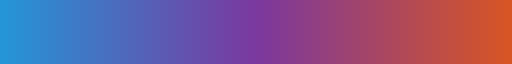

In [43]:
c1 = np.array([0.147, 0.586, 0.845, 1.0])

c11 = np.array([0.484, 0.222, 0.624, 1.0])
c2 = np.array([0.845, 0.335, 0.147, 1.0])
new_cmap = LinearSegmentedColormap.from_list('two_colors', (c1, c11, c2), N=64)
new_cmap

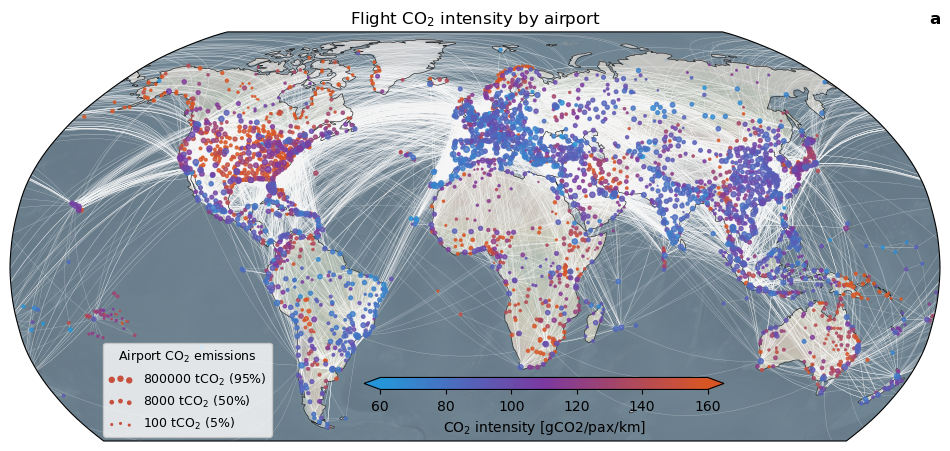

In [48]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
cax = fig.add_axes([0.42, 0.24, 0.3, 0.02])

# ax.set_global()
ax.set_extent([-180, 180, -60, 90])
ax.add_feature(cfeature.OCEAN,facecolor="0.4",zorder=-2)
ax.add_feature(cfeature.LAND,facecolor="0.7", zorder=-1)
# ax.add_feature(cfeature.OCEAN,facecolor="#4381a2",zorder=-2)
# ax.add_feature(cfeature.LAND,facecolor="#63a1c2", zorder=-1)
ax.stock_img(alpha=0.4)
ax.coastlines(color="k", alpha=0.8, lw=0.5, zorder=.2)

ax.plot(np.vstack((longitude_departure, longitude_arrival)),
        np.vstack((latitude_departure, latitude_arrival)), color="w", lw=.2, alpha=0.3, transform=ccrs.Geodetic(), zorder=.1)

vmin, vmax = 60, 160
h = ax.scatter(0, 0, 0, 0, vmin=vmin, vmax=vmax, alpha=1, cmap=new_cmap, visible=False)

f = lambda x: 7e-2*np.log(x)**2
ax.scatter(0, -100, f(p95), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:.0f} tCO$_2$ (95%)".format(p95))
ax.scatter(0, -100, f(p50), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:.0f} tCO$_2$ (50%)".format(p50))
ax.scatter(0, -100, f(p5), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:.0f} tCO$_2$ (5%)".format(p5))

ax.legend(loc=(0.1, 0.01), scatterpoints=3, fontsize=9, title="Airport CO$_2$ emissions", title_fontsize=9)

ax.scatter(longitude_airport, latitude_airport, f(carbon), mean_intensity,
               vmin=vmin, vmax=vmax, alpha=0.8, cmap=new_cmap, transform=ccrs.PlateCarree())

fig.colorbar(h, cax=cax, orientation='horizontal', label="CO$_2$ intensity [gCO2/pax/km]", extend="both")

ax.set_title("Flight CO$_2$ intensity by airport")
ax.set_title("a", loc="right", fontweight="bold")

plt.show()

Fig. ?: CO2 intensity per flight connection. Thin black lines denote the flight path between two airports along the respective great circle (actual paths include detours, holding, etc.). Departure airports are marked by location and colour-coded to show the carbon intensity, in carbon emissions (gCO2) through fuel burn by aircraft type, per passenger (average load factor for that flight connection), per flown kilometre (accounting for detours or holding).

# Plot only America, Europe, and East Asia

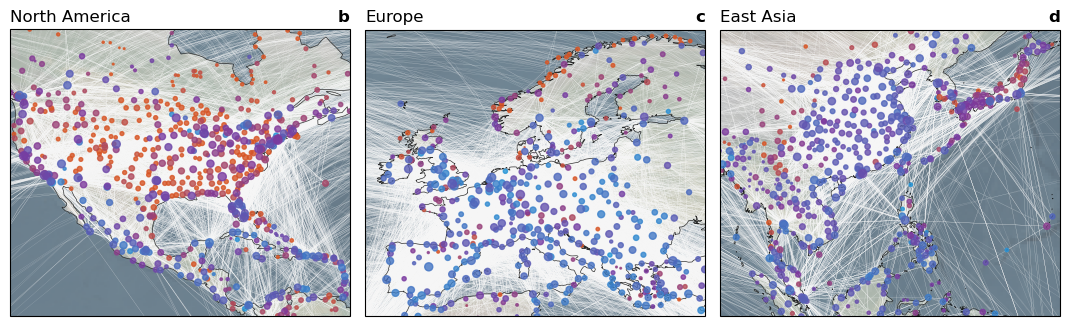

In [47]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree(central_longitude=-100))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree(central_longitude=10))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree(central_longitude=120))

ax1.set_extent([-125, -60, 7, 58], crs=ccrs.Geodetic())
ax2.set_extent([-12, 33, 34, 70.5], crs=ccrs.Geodetic())
ax3.set_extent([90, 147, -1.5, 43], crs=ccrs.Geodetic())

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

ax1p = ax1.get_position()
x1, y1, _, _ = ax1p.bounds

ax3p = ax3.get_position()
x3, y3, w, h = ax3p.bounds

# cax = fig.add_axes([x1, y1-0.04, x3+w-x1, 0.02])
# cax = fig.add_axes([x3+w+0.01, y3, 0.02, h])

for ax in (ax1, ax2, ax3):
    ax.add_feature(cfeature.OCEAN,facecolor="0.4",zorder=-2)
    ax.add_feature(cfeature.LAND,facecolor="0.7", zorder=-1)
    # ax.add_feature(cfeature.OCEAN,facecolor="#4381a2",zorder=-2)
    # ax.add_feature(cfeature.LAND,facecolor="#63a1c2", zorder=-1)
    ax.stock_img(alpha=0.4)
    ax.coastlines(color="k", alpha=0.8, lw=0.5, zorder=.2)


vmin, vmax = 60, 160
h = ax1.scatter(0, 0, 0, 0, vmin=vmin, vmax=vmax, alpha=1, cmap="viridis_r", visible=False)

for ax in (ax1, ax2, ax3):
    ax.plot(np.vstack((longitude_departure, longitude_arrival)),
            np.vstack((latitude_departure, latitude_arrival)), color="w", lw=.2, alpha=0.3, transform=ccrs.Geodetic(), zorder=.1)
    ax.scatter(longitude_airport, latitude_airport,2*f(carbon), mean_intensity,
               vmin=vmin, vmax=vmax, alpha=0.8, cmap=new_cmap, transform=ccrs.PlateCarree())

# fig.colorbar(h, cax=cax, orientation='vertical', label="Flight carbon intensity [gCO2/pax/km]", extend="both")

ax1.set_title("North America", loc="left")
ax2.set_title("Europe", loc="left")
ax3.set_title("East Asia", loc="left")

ax1.set_title("b", loc="right", fontweight="bold")
ax2.set_title("c", loc="right", fontweight="bold")
ax3.set_title("d", loc="right", fontweight="bold")

plt.show()

Fig. ?: As Fig. ? but zooming into (a) North America, (b) Europe, (c) East Asia.